# 💸 Scenario A Scaffold

by Denis Tsimafeyenka and Kyle Furey

## 📥 Load and Inspect the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

sns.set_theme(style='whitegrid')

## Read Data File


In [2]:
# Read the CSV data
data = pd.read_csv('scenario_A_data.csv')

# Simplify the data into rows of each feature
# 0 indicates to the algorithm that the feature is nonpresent
# 1 indicates to the algorithm that the feature is present
data = pd.get_dummies(data).astype(int)
data.head()
data.info()

# Separate the features from the results
X = data.drop(columns=['default'])
y = data['default']

# Separate data by result
zero_indices = y[y == 0].index
one_indices = y[y == 1].index

# Sample a near equal amount of 0 and 1 results
np.random.seed(42)
kept_indices = np.random.choice(zero_indices, size=len(one_indices) * 10, replace=False)
kept_indices = np.concatenate([kept_indices, one_indices])

# Retain only an equal dataset containing a matching amount of 0 and 1
X = X.loc[kept_indices]
y = y.loc[kept_indices]

# Display the features as a table
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   age                              1000 non-null   int64
 1   income                           1000 non-null   int64
 2   loan_amount                      1000 non-null   int64
 3   loan_term                        1000 non-null   int64
 4   credit_score                     1000 non-null   int64
 5   default                          1000 non-null   int64
 6   employment_status_Employed       1000 non-null   int64
 7   employment_status_Self-employed  1000 non-null   int64
 8   employment_status_Unemployed     1000 non-null   int64
 9   housing_status_Mortgage          1000 non-null   int64
 10  housing_status_Own               1000 non-null   int64
 11  housing_status_Rent              1000 non-null   int64
dtypes: int64(12)
memory usage: 93.9 KB


,age,income,loan_amount,loan_term,credit_score,employment_status_Employed,employment_status_Self-employed,employment_status_Unemployed,housing_status_Mortgage,housing_status_Own,housing_status_Rent
804,37,65881,27064,60,660,1,0,0,0,0,1
450,40,56171,23797,12,654,0,0,1,0,1,0
140,46,65109,23894,36,744,0,1,0,0,1,0
711,42,50313,22498,12,632,0,0,1,0,1,0
67,24,69596,24123,24,711,0,1,0,0,1,0


## Check Class Distribution

In [3]:
# Display the results (defaults) of the data
y.value_counts()

default
0    200
1     20
Name: count, dtype: int64

## Preprocess Categorical Variables

## Split Data into Training and Testing Sets

In [4]:
# Split the data into training sets, testing sets, and validating sets
# 1. train + temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
print(f"y_train: {y_train.value_counts()}")
print(f"y_temp: {y_temp.value_counts()}")

# 2. validation + test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f"y_val: {y_val.value_counts()}")
print(f"y_test: {y_test.value_counts()}")

y_train: default
0    120
1     12
Name: count, dtype: int64
y_temp: default
0    80
1     8
Name: count, dtype: int64
y_val: default
0    40
1     4
Name: count, dtype: int64
y_test: default
0    40
1     4
Name: count, dtype: int64


## Train Random Forest Classifier

In [5]:
# RandomForestClassifier algorithm
model = RandomForestClassifier( 
    n_estimators=400, 
    min_samples_leaf=4,# trying to raise recall
    class_weight='balanced_subsample',
    random_state=42)
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]

# getting prediction to validate best threshold 
y_proba_val = model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_proba_val)

Best threshold by F1 = 0.323, F1 = 1.000


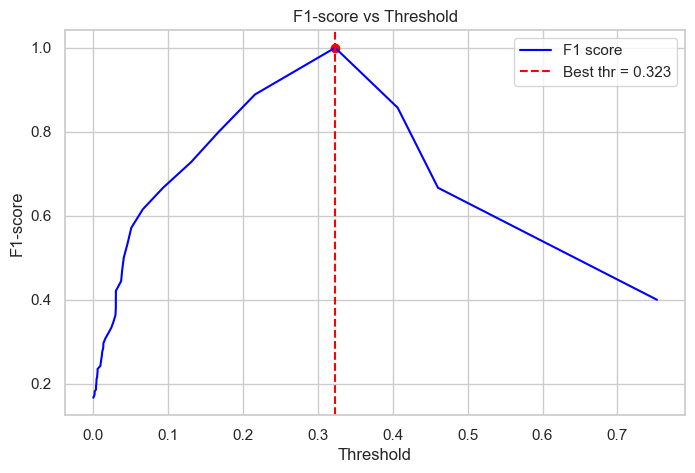

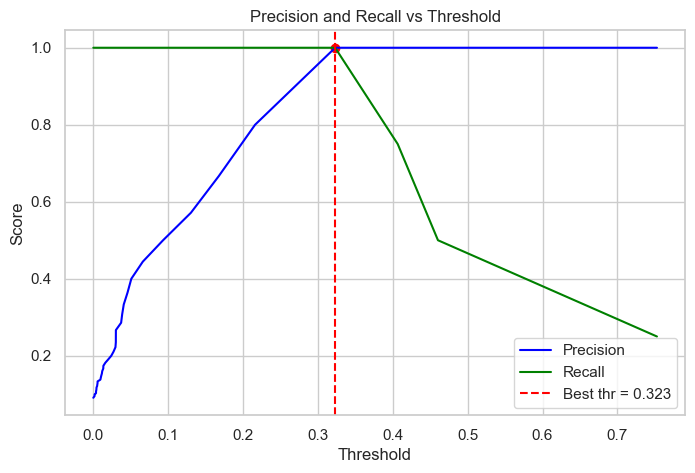

In [6]:
f1 = 2 * prec * rec / (prec + rec + 1e-9)

# getting best threshold
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx]
best_f1 = f1[best_idx]


print(f"Best threshold by F1 = {best_thr:.3f}, F1 = {best_f1:.3f}")

# F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thr, f1[:-1], label="F1 score", color='blue')  # thr на 1 короче
plt.axvline(best_thr, color='red', linestyle='--', label=f'Best thr = {best_thr:.3f}')
plt.scatter([best_thr], [best_f1], color='red')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Precision and Recall vs Threshold
plt.figure(figsize=(8,5))
plt.plot(thr, prec[:-1], label="Precision", color='blue')
plt.plot(thr, rec[:-1], label="Recall", color='green')
plt.axvline(best_thr, color='red', linestyle='--', label=f'Best thr = {best_thr:.3f}')
plt.scatter([best_thr], [best_f1], color='red')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# RandomForestClassifier using predict with 0.5 threshold
# Store thresholds for testing
threshold = best_thr
print(f'RandomForestClassifier')
print('-' * 55)

y_pred_new = (y_proba >= threshold).astype(int)
print(f'Predict_Proba and Threshold = {threshold}')
print(confusion_matrix(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))
print('-' * 55)

RandomForestClassifier
-------------------------------------------------------
Predict_Proba and Threshold = 0.3230316633951496
[[39  1]
 [ 0  4]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.80      1.00      0.89         4

    accuracy                           0.98        44
   macro avg       0.90      0.99      0.94        44
weighted avg       0.98      0.98      0.98        44

-------------------------------------------------------


## Train with Logistic Regression

In [8]:
# # Store 3 thresholds for testing
# thresholds = [0.65]

# # LogisticRegression using predict with threshold 0.5
# print(f'LogisticRegression')
# print('-' * 55)

# model = LogisticRegression(max_iter=10000)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# print(f'Predict')
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))
# print('-' * 55)

# # LogisticRegression using predict_proba and test threshold 0.3 0.5 0.7
# y_proba = model.predict_proba(X_test)[:, 1]

# for threshold in thresholds:
#     y_pred_new = (y_proba >= threshold).astype(int)
#     print(f'Predict_Proba and Threshold = {threshold}')
#     print(confusion_matrix(y_test, y_pred_new))
#     print(classification_report(y_test, y_pred_new))
#     print('-' * 55)

In [9]:
# coef = pd.Series(model.coef_[0], index=X_train.columns)
# coef_abs = coef.abs().sort_values(ascending=False)

# coef_abs.head(10).plot(kind='barh')
# plt.title('Top 10 Feature Importances (from the model)')
# plt.gca().invert_yaxis()
# plt.show()

## Model Evaluation

ROC AUC: 0.9874999999999999


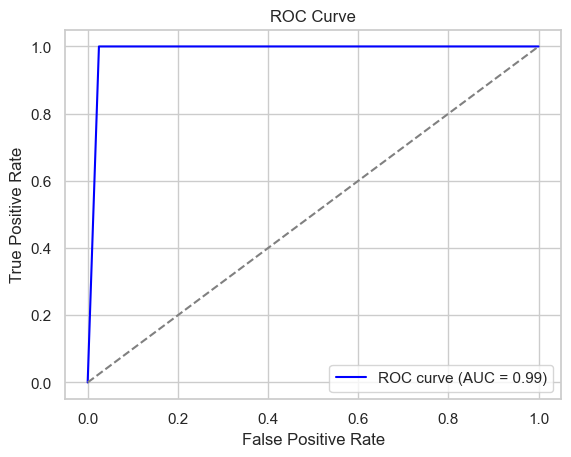

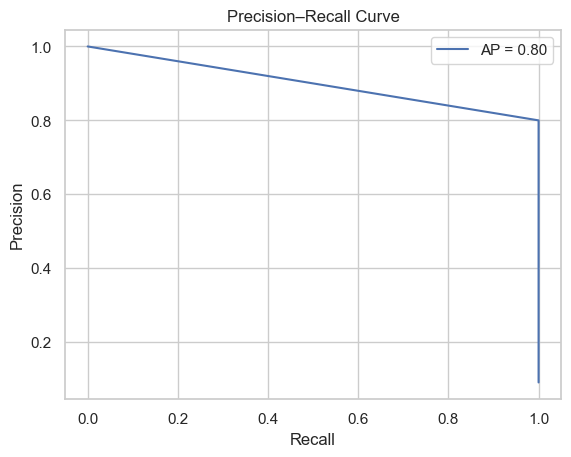

In [10]:
roc_auc = roc_auc_score(y_test, y_pred_new)
print('ROC AUC:', roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_new)
roc_auc = auc(fpr, tpr)

# Plot a ROC curve with our data
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

prec, rec, thr = precision_recall_curve(y_test, y_pred_new)
ap = average_precision_score(y_test, y_pred_new)
plt.figure()
plt.plot(rec, prec, label=f'AP = {ap:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curve'); plt.legend(); plt.show()

## Feature Importance

In [11]:
# Display correlations of each feature
X.corrwith(y).abs().sort_values(ascending=False)

loan_amount                        0.661448
credit_score                       0.620914
income                             0.562293
employment_status_Employed         0.127020
employment_status_Unemployed       0.083012
age                                0.045943
employment_status_Self-employed    0.041833
loan_term                          0.037608
housing_status_Mortgage            0.037480
housing_status_Rent                0.018447
housing_status_Own                 0.017836
dtype: float64

With a dataset containing only 2% of defaulting results, nearly every feature is critical to ML's prediction on whether a default may occur.

However, if we want to truly boost the results and accuracy of the model, we would need a more even dataset of the results (y). Training the model in this current state yields high results because 98% of the data does not default.

Dropping the weakest correlating features may not affect the performance of the model in its current state. However, if more data with more default results is trained on, we may find those dropped features have a stronger correlation to a successful prediction.